# Diffusion model

We consider a Gaussian Mixture target 
\begin{equation}
    q_0 = \sum_{k=1}^K w_k \mathcal{N}(x; m_k, C_k)
\end{equation}

## Forward process

The forward process
\begin{align*}
   &dX_t = -\frac{\beta_t}{2}X_t dt + \sqrt{\beta_t} dB_t, \qquad X_0  \sim q_0, \qquad 0 \leq t \leq T  \\
   &\beta_t = \beta_{\rm min} + \frac{t}{T} (\beta_{\rm max} - \beta_{\rm min})  \\
\end{align*}

Then we have  $X_t \sim \lambda_t X_0 + \sigma_t W, \qquad W\sim N(0,I)$ with 
\begin{align*}
\lambda_t = e^{-\frac{1}{2}\Bigl(t \beta_{\rm min} + \frac{t^2}{2T}(\beta_{\rm max} - \beta_{\rm min})\Bigr)} 
\quad \textrm{and} \quad  \sigma_t = \sqrt{1 - \lambda_t^2}
\end{align*} 

The density satisfies
\begin{align*}
	q_t(y) = &  \int_{R^d} \frac{1}{(\sqrt{2\pi} \sigma_t)^d} \cdot \exp \left( -\frac{\|y - \lambda_t x\|_2^2}{2\sigma_t^2} \right) q_0(x) \mathrm{d} x \\
	= & \sum_{k=1}^K w_k \mathcal{N}(y; \lambda_t m_k, \lambda_t^2 C_k + \sigma_t^2 I)
\end{align*}

The score function is 
\begin{align*}
	\nabla_x \log q_t(x)
	= & -\sum_{k=1}^K\frac{w_k\mathcal{N}(x; \lambda_t m_k, \lambda_t^2 C_k + \sigma_t^2 I)}{q_t(x)} (\lambda_t^2C_k + \sigma_t^2I)^{-1}(x - \lambda_t m_k)
\end{align*}

## Backward process

To generate samples, we need to implement the backward process
\begin{align*}
    \partial_t \rho_t = -\frac{\beta_{T-t}}{2}\nabla \cdot ((x + \nabla \log q_{T - t})\rho_t)    \qquad 0 \leq t \leq T
\end{align*}
which can be converted probability flow ODE
\begin{align*}
    dY_t =  \frac{\beta_{T-t}}{2}\Bigl(Y_t + \nabla \log q_{T - t}(Y_t)\Bigr)  \qquad  Y_0 \sim N(0,I)   \qquad 0 \leq t \leq T
\end{align*}

We further denote 
\begin{align*}
\zeta(t) = \frac{1}{2}\int_{T-t}^{T} \beta_s  ds = \frac{1}{2}t\beta_{\rm max} - \frac{t^2}{4T}(\beta_{\rm max} - \beta_{\rm min}) \qquad
\alpha_t = \zeta(t) - \log \sigma_{T - t}
\end{align*}

In [1]:
using PyPlot
using LinearAlgebra
using Random 
using Distributions
using KernelDensity 
using NPZ

# Gaussian mixture score computation

In [2]:
"""
    Gaussian_density(x_mean::Array{FT,1}, xx_cov, x::Array{FT,1}; propto::Bool=true, xx_prec=nothing, det_xx_cov=nothing) where {FT<:AbstractFloat}

Compute the multivariate Gaussian density at point `x`, given mean `x_mean` and covariance matrix `xx_cov`.

# Arguments
- `x_mean::Array{FT,1}`: Mean vector of the Gaussian distribution.
- `xx_cov`: Covariance matrix (can be any matrix type compatible with `\` and `det`).
- `x::Array{FT,1}`: Point at which the density is evaluated.
- `propto::Bool=true`: If `true`, omit constant normalization factor `(2π)^(d/2)`.
- `xx_prec`: Optional precision matrix (inverse of `xx_cov`). If not provided, it is computed implicitly via backslash operator.
- `det_xx_cov`: Optional determinant of `xx_cov`. If not provided, it is computed using `det(xx_cov)`.

# Returns
- Scalar value: the (possibly unnormalized) Gaussian density at `x`.

# Notes
- To avoid redundant computations, `xx_prec` and `det_xx_cov` can be precomputed and passed as arguments.
- For large-scale problems, consider using more numerically stable methods for computing the log-density.
"""
function Gaussian_density(x_mean::Array{FT,1}, xx_cov, x::Array{FT,1}; propto::Bool= true, xx_prec = nothing, det_xx_cov = nothing) where {FT<:AbstractFloat}
    N_x = size(x_mean,1)
    if det_xx_cov === nothing
        det_xx_cov = det(xx_cov)
    end
    Cinv_x =  (xx_prec === nothing ? xx_cov\(x - x_mean) : xx_prec*(x - x_mean))
        
    Z = (propto ? sqrt(det_xx_cov) : (2π)^(N_x/2)*sqrt(det_xx_cov))
    return exp( -1/2*((x - x_mean)'* Cinv_x)) / Z

end


"""
    Gaussian_mixture_density(x_w::Array{FT,1}, x_mean::Array{FT,2}, xx_cov, x::Array{FT,1}; 
                             propto::Bool=true, xx_prec=nothing, det_xx_cov=nothing) 
                             where {FT<:AbstractFloat}

Compute the (possibly unnormalized) density of a Gaussian mixture model (GMM) at a point `x`.

# Arguments
- `x_w::Array{FT,1}`: Weights for each Gaussian component (should sum to 1 for a valid GMM).
- `x_mean::Array{FT,2}`: A matrix where each row is the mean of a Gaussian component (size: N_modes × dim).
- `xx_cov`: A collection (e.g., vector of matrices) of covariance matrices, one per component.
- `x::Array{FT,1}`: The point at which the density is evaluated.
- `propto::Bool=true`: Whether to omit the `(2π)^(d/2)` constant in the density.
- `xx_prec`: Optional precomputed precision matrices (inverse of covariances).
- `det_xx_cov`: Optional precomputed determinants of covariance matrices.

# Returns
- Scalar value: the (possibly unnormalized) mixture density at point `x`.

# Notes
- Precomputing precision and determinant arrays can improve performance.
"""
function Gaussian_mixture_density(x_w::Array{FT,1}, x_mean::Array{FT,2}, xx_cov, x::Array{FT,1}; propto::Bool= true, xx_prec = nothing, det_xx_cov = nothing) where {FT<:AbstractFloat}
    ρ = 0.0
    N_modes, dim = size(x_mean)
    
    for i = 1:N_modes
        ρ += x_w[i]*Gaussian_density(x_mean[i,:], xx_cov[i], x; propto = propto, 
        xx_prec = (xx_prec === nothing ? nothing : xx_prec[i]),
        det_xx_cov = (det_xx_cov === nothing ? nothing : det_xx_cov[i]))
    end
    
    return ρ
end


"""
    Gaussian_mixture_score_function(x_w::Array{FT,1}, x_mean::Array{FT,2}, xx_cov, x::Array{FT,1}; 
                                    xx_prec=nothing, det_xx_cov=nothing) 
                                    where {FT<:AbstractFloat}

Compute the score function (∇ log p(x)) of a Gaussian mixture model at a point `x`.

# Arguments
- `x_w::Array{FT,1}`: Mixture weights for each component.
- `x_mean::Array{FT,2}`: Matrix of component means, each row is one mean vector.
- `xx_cov`: Collection of covariance matrices.
- `x::Array{FT,1}`: Point at which to evaluate the score function.
- `xx_prec`: Optional precomputed precision matrices.
- `det_xx_cov`: Optional precomputed determinants of covariance matrices.

# Returns
- `∇logρ`: The gradient of the log-density at `x` (i.e., the score function).

# Notes
- This implementation assumes the score is with respect to `x`.
- Can be used in variational inference, diffusion models, and MCMC.
"""
function Gaussian_mixture_score_function(x_w::Array{FT,1}, x_mean::Array{FT,2}, xx_cov, x::Array{FT,1}; xx_prec = nothing, det_xx_cov = nothing) where {FT<:AbstractFloat}
    N_modes, dim = size(x_mean)
    ρ = Gaussian_mixture_density(x_w, x_mean, xx_cov, x; propto= true, xx_prec = xx_prec, det_xx_cov = det_xx_cov)
    ∇logρ = zeros(FT, dim)
    for i = 1:N_modes
        Cinv_x =  (xx_prec === nothing ? xx_cov[i]\(x_mean[i,:] - x) : xx_prec[i]*(x_mean[i,:] - x))
        
        ∇logρ += x_w[i]*Gaussian_density(x_mean[i,:], xx_cov[i], x; propto = true, 
        xx_prec = (xx_prec === nothing ? nothing : xx_prec[i]),
        det_xx_cov = (det_xx_cov === nothing ? nothing : det_xx_cov[i])) * Cinv_x
    end
    ∇logρ /= ρ
    
    return ∇logρ
end

Gaussian_mixture_score_function

# Linear beta scheduler

In [3]:
# Linear Schedule
struct Beta_Schedule
    beta_min::Float64
    beta_max::Float64
    T::Float64
end

function compute_beta(bs::Beta_Schedule, t::Float64)
    beta_min, beta_max, T = bs.beta_min, bs.beta_max, bs.T  
    return (beta_min + t/T*(beta_max-beta_min))
end

function compute_mt_covt(bs::Beta_Schedule, t::Float64)
    beta_min, beta_max, T = bs.beta_min, bs.beta_max, bs.T  
    λ_t =  exp(-1/2*(t*beta_min + t*t/(2T)*(beta_max - beta_min)))
    σ_t =  sqrt(1 - λ_t*λ_t) 
    return λ_t, σ_t
end

function compute_zeta(bs::Beta_Schedule, t::Float64)
    beta_min, beta_max, T = bs.beta_min, bs.beta_max, bs.T  
    zeta_t =  t/2*beta_max - t*t/(4T)*(beta_max - beta_min)
    return zeta_t
end

function compute_alpha(bs::Beta_Schedule, t::Float64)
    beta_min, beta_max, T = bs.beta_min, bs.beta_max, bs.T  
    zeta_t =  compute_zeta(bs, t)
    _, σ_T_t = compute_mt_covt(bs, T - t)
    return zeta_t - log(σ_T_t)
end

compute_alpha (generic function with 1 method)

In [4]:
"""
Propagate a Gaussian Mixture Model (GMM) through the forward diffusion process at time t.

Each Gaussian component (mean and covariance) is updated based on the diffusion dynamics:
    x(t) = λ_t * x(0) + σ_t * ε, 
    Specifically, for OU process, λ_t = exp(-t), σ_t = sqrt(1 - exp(-2t))

Arguments:
- x_w      : Weights of the Gaussian components.
- x_mean   : Means of the GMM components.
- xx_cov   : Covariances of the GMM components (array of matrices).
- t        : Diffusion time.
- T        : End time
- linear_betas    : linear scheduler parameters

Returns:
- x_mean_t : Updated means of the GMM components at time t.
- xx_cov_t : Updated covariances of the GMM components at time t.
"""
function compute_mt_covt(x_w::Array{FT,1}, x_mean::Array{FT,2}, xx_cov, t::FT, bs::Beta_Schedule) where {FT<:AbstractFloat}
    N_modes, N_x = size(x_mean)
    x_mean_t = copy(x_mean)
    xx_cov_t = []  
    
    λ_t , σ_t =  compute_mt_covt(bs, t)

            
    for i = 1:N_modes
        x_mean_t[i,:] = λ_t*x_mean[i,:]
        push!(xx_cov_t, λ_t^2*xx_cov[i] + σ_t^2*I)
    end
    return x_mean_t, xx_cov_t
end

"""
Propagate a Gaussian Mixture Model (GMM) through the forward diffusion process, 
and compute the density q_t(x) at time t for a single sample x.

This evaluates the density of the time-evolved GMM at a given point x.

Arguments:
- x_w      : Weights of the GMM components.
- x_mean   : Means of the GMM components.
- xx_cov   : Covariances of the GMM components.
- x        : A single point where the density is evaluated.
- t        : Diffusion time.
- T        : End time
- linear_betas    : linear scheduler parameters

Returns:
- qt       : Value of q_t(x).
"""
function compute_qt(x_w::Array{FT,1}, x_mean::Array{FT,2}, xx_cov, x::Array{FT,1}, t::FT,  bs::Beta_Schedule) where {FT<:AbstractFloat}
    N_modes, _ = size(x_mean)
    x_mean_t, xx_cov_t = compute_mt_covt(x_w, x_mean, xx_cov, t, bs)
    qt = Gaussian_mixture_density(x_w, x_mean_t, xx_cov_t, x; propto= false)
    return qt
end


"""
Propagate a Gaussian Mixture Model (GMM) through the forward diffusion process, 
and compute the density q_t(x) at time t for a batch of samples xx.

Uses precomputed inverse covariances and determinants for efficient evaluation.

Arguments:
- x_w        : Weights of the GMM components.
- x_mean     : Means of the GMM components.
- xx_cov     : Covariances of the GMM components.
- xx         : Array of N samples (N x dim) to evaluate q_t at.
- t          : Diffusion time.
- T          : End time
- linear_betas    : linear scheduler parameters

Returns:
- qt         : Array of q_t(x) values for each row in xx.
"""
function compute_qt(x_w::Array{FT,1}, x_mean::Array{FT,2}, xx_cov, xx::Array{FT,2}, t::FT,  bs::Beta_Schedule) where {FT<:AbstractFloat}
    N_modes, dim = size(x_mean)
    N_x = size(xx, 1)
    x_mean_t, xx_cov_t = compute_mt_covt(x_w, x_mean, xx_cov, t, bs)
    
    det_xx_cov_t = zeros(N_modes)
    xx_prec_t = []
    for im = 1:N_modes
        det_xx_cov_t[im] = det(xx_cov_t[im])
        push!(xx_prec_t, inv(xx_cov_t[im]))
    end
    
    qt = zeros(N_x)
    for i = 1:N_x
        qt[i] = Gaussian_mixture_density(x_w, x_mean_t, xx_cov_t, xx[i,:]; propto= false, det_xx_cov=det_xx_cov_t, xx_prec = xx_prec_t)
    end
    return qt
end

"""
Propagate a Gaussian Mixture Model (GMM) through the forward diffusion process, 
and compute the score function ∇log q_t(x) at time t for a single sample x.

The score is the gradient of the log-density of the time-evolved GMM at x.

Arguments:
- x_w      : Weights of the GMM components.
- x_mean   : Means of the GMM components.
- xx_cov   : Covariances of the GMM components.
- x        : A single sample.
- t          : Diffusion time.
- T          : End time
- linear_betas    : linear scheduler parameters
Returns:
- ∇logqt   : Gradient of log q_t(x) with respect to x.
"""
function compute_qt_score(x_w::Array{FT,1}, x_mean::Array{FT,2}, xx_cov, x::Array{FT,1}, t::FT,  bs::Beta_Schedule) where {FT<:AbstractFloat}
    N_modes, dim = size(x_mean)
    x_mean_t, xx_cov_t = compute_mt_covt(x_w, x_mean, xx_cov, t, bs)
    ∇logqt = Gaussian_mixture_score_function(x_w, x_mean_t, xx_cov_t, x) 
    return ∇logqt
end


"""
Propagate a Gaussian Mixture Model (GMM) through the forward diffusion process, 
and compute the score function ∇log q_t(x) at time t for a batch of samples xx.

The score is the gradient of the log-density of the time-evolved GMM at x.

Arguments:
- x_w      : Weights of the GMM components.
- x_mean   : Means of the GMM components.
- xx_cov   : Covariances of the GMM components.
- x        : A single sample.
- t        : Diffusion time.
- T        : End time
- linear_betas    : linear scheduler parameters
Returns:
- ∇logqt   : Gradient of log q_t(x) with respect to x.
"""
function compute_qt_score(x_w::Array{FT,1}, x_mean::Array{FT,2}, xx_cov, xx::Array{FT,2}, t::FT,  bs::Beta_Schedule) where {FT<:AbstractFloat}
    N_modes, dim = size(x_mean)
    N_x = size(xx, 1)
    x_mean_t, xx_cov_t = compute_mt_covt(x_w, x_mean, xx_cov, t, bs)
    
    sqrt_xx_prec_t = []
    det_sqrt_xx_prec_t = zeros(N_modes)
    for im = 1:N_modes
        
        push!(sqrt_xx_prec_t, inv(cholesky(xx_cov_t[im]).L))
        det_sqrt_xx_prec_t[im] = det(sqrt_xx_prec_t[im])
    end

    
    qt, ∇logqt = zeros(FT, N_x), zeros(FT, N_x, dim)

    for im in 1:N_modes
        x_p_demeaned = xx .- x_mean_t[im,:]'                                          
        norm_const = det_sqrt_xx_prec_t[im]                                         
        Cinv_x_p_demeaned =  x_p_demeaned * (sqrt_xx_prec_t[im]' * sqrt_xx_prec_t[im])
        
        ρt = x_w[im] * norm_const * exp.(-0.5 * vec(sum(Cinv_x_p_demeaned .* x_p_demeaned, dims=2)))   
        
        qt .+= ρt                      
        ∇logqt .-= Cinv_x_p_demeaned .* ρt
    end
    return ∇logqt ./ qt
end

"""
    compute_U_GM(x_w::Array{FT,1}, x_mean::Array{FT,2}, xx_cov, t::FT, T::FT, xx::Union{Array{FT,1},Array{FT,2}})

Compute the drift term `U(t, x)` used in the reverse-time probability flow ODEs.
This function implements:
    U(t, x) = x + ∇log q_{T-t}(x)
where ∇log q_{T-t}(x) is the score of the Gaussian mixture at time (T - t).

# Arguments
- `x_w::Array{FT,1}`: Weights of each Gaussian component in the mixture.
- `x_mean::Array{FT,2}`: Means of each Gaussian component (size: N_modes × dim).
- `xx_cov`: Covariance matrices of the Gaussian components (vector of matrices).
- `xx::Union{Array{FT,1},Array{FT,2}}`: Points at which to evaluate the drift (size: N_x × dim or N_x).

- `t::FT`: Current time in the reverse diffusion process.
- `T::FT`: Total diffusion time (end of forward process).
- linear_betas    : linear scheduler parameters
# Returns
- `U(t, x)` evaluated at each point in `xx`, using the score of the time-reversed
  Gaussian mixture at time `T - t`.

"""
function compute_U_GM(x_w::Array{FT,1}, x_mean::Array{FT,2}, xx_cov, xx::Union{Array{FT,1},Array{FT,2}}, t::FT, bs::Beta_Schedule) where {FT<:AbstractFloat}
    xx = (ndims(xx) == 1 ? Array(reshape(xx, (length(xx), 1))) : xx)
    N_modes, dim = size(x_mean)
    N_x = size(xx, 1)
    ∇logqt = compute_qt_score(x_w, x_mean, xx_cov, xx, bs.T-t, bs)
    return xx + ∇logqt
end




compute_U_GM

We assume that we have access  to an imperfect score function characterized by the following artificial score errors $\delta(x) = s_{t}(x) - \nabla \log q_t(x)$

\begin{align*}
&\delta(x) = \frac{\tilde{\delta}(x[1])}{\sqrt{d}} 
\\
&\tilde{\delta}''(x) = \begin{cases} 1 & \lfloor{x\rfloor} = 2n  \\ -1 & \lfloor{x\rfloor} = 2n+1
\end{cases}\qquad
\tilde{\delta}'(x) = \begin{cases} x - \lfloor{x\rfloor} & \lfloor{x\rfloor} = 2n  \\ 
                                   1 + \lfloor{x\rfloor} - x & \lfloor{x\rfloor} = 2n+1
\end{cases}\qquad
\tilde{\delta}(x) = \begin{cases} n+\frac{(x - \lfloor{x\rfloor})^2}{2} & \lfloor{x\rfloor} = 2n  \\ n+1 - \frac{(1 + \lfloor{x\rfloor} -x)^2}{2} & \lfloor{x\rfloor} = 2n+1
\end{cases}
\end{align*}


In [5]:
"""
    score_error(x_w::Array{FT,1}, x_mean::Array{FT,2}, xx_cov, δ::FT, t::FT, T::FT, xx::Array{FT,2}) where {FT<:AbstractFloat}

Add controlled perturbations (or noise) to the score function ∇log q_t(x) for experimental purposes.

# Arguments
- `x_w::Array{FT,1}`: Weights of the Gaussian mixture components.
- `x_mean::Array{FT,2}`: Means of the Gaussian components (N_modes × dim).
- `xx_cov`: Covariances of the Gaussian components (not used in this function but may be for extension).
- `δ::FT`: Magnitude of the perturbation (controls error scale).
- `t::FT`: Current time in the diffusion process (not used here, but included for extensibility).
- `T::FT`: Total diffusion time (also not used in this function).
- `xx::Array{FT,2}`: Input points at which the error is evaluated (N_x × dim).

# Returns
- An N_x × dim matrix containing the synthetic perturbation added to the score function.
"""
function score_error(δ::FT, xx::Array{FT,2}) where {FT<:AbstractFloat}

    N_x, dim = size(xx)
    xx1 = xx[:, 1]
    s1 = map(x1 -> begin 
            f = floor(Int, x1) 
            iseven(f) ? f/2 + (x1 - f)^2/2 : (f+1)/2 - (1 + f - x1)^2/2 
            end, xx1)

    ds =  δ/sqrt(dim) *  (s1  *ones(dim)')
    return ds
end


"""
    compute_RHS(x_w::Array{FT,1}, x_mean::Array{FT,2}, xx_cov, t::FT, T::FT, xx::Union{Array{FT,1},Array{FT,2}})

Compute the drift term `U(t, x)` used in the reverse-time probability flow ODEs.
This function implements:
    U(t, x) = (x + ∇log q_{T-t}(x) + delta)
where ∇log q_{T-t}(x) is the score of the Gaussian mixture at time (T - t).

# Arguments
- `x_w::Array{FT,1}`: Weights of each Gaussian component in the mixture.
- `x_mean::Array{FT,2}`: Means of each Gaussian component (size: N_modes × dim).
- `xx_cov`: Covariance matrices of the Gaussian components (vector of matrices).
- `xx::Union{Array{FT,1},Array{FT,2}}`: Points at which to evaluate the drift (size: N_x × dim or N_x).

- `t::FT`: Current time in the reverse diffusion process.
- `T::FT`: Total diffusion time (end of forward process).
- `linear_betas`    : linear scheduler parameters
# Returns
- `U(t, x)` evaluated at each point in `xx`, using the score of the time-reversed
  Gaussian mixture at time `T - t`.

"""

function compute_RHS(x_w::Array{FT,1}, x_mean::Array{FT,2}, xx_cov, xx::Union{Array{FT,1},Array{FT,2}}, t::FT, bs::Beta_Schedule, δ::FT=0.0) where {FT<:AbstractFloat}
    xx = (ndims(xx) == 1 ? Array(reshape(xx, (length(xx), 1))) : xx)
    rhs = compute_U_GM(x_w, x_mean, xx_cov, xx, t, bs) + score_error(δ, xx)
    return compute_beta(bs, bs.T-t)/2.0 * rhs
end


function compute_score(x_w::Array{FT,1}, x_mean::Array{FT,2}, xx_cov, xx::Union{Array{FT,1},Array{FT,2}}, t::FT, bs::Beta_Schedule, δ::FT=0.0) where {FT<:AbstractFloat}
    xx = (ndims(xx) == 1 ? Array(reshape(xx, (length(xx), 1))) : xx)
    N_modes, dim = size(x_mean)
    N_x = size(xx, 1)
    ∇logqt = compute_qt_score(x_w, x_mean, xx_cov, xx, bs.T-t, bs)
    return ∇logqt + score_error(δ, xx)
end


function compute_varepsilon(x_w::Array{FT,1}, x_mean::Array{FT,2}, xx_cov, xx::Union{Array{FT,1},Array{FT,2}}, t::FT, bs::Beta_Schedule, δ::FT=0.0) where {FT<:AbstractFloat}
    xx = (ndims(xx) == 1 ? Array(reshape(xx, (length(xx), 1))) : xx)
    N_modes, dim = size(x_mean)
    N_x = size(xx, 1)
    ∇logqt = compute_qt_score(x_w, x_mean, xx_cov, xx, bs.T-t, bs)
    _, σ_T_t = compute_mt_covt(bs, bs.T - t)
    
    return (∇logqt + score_error(δ, xx))*σ_T_t
end




compute_varepsilon (generic function with 2 methods)

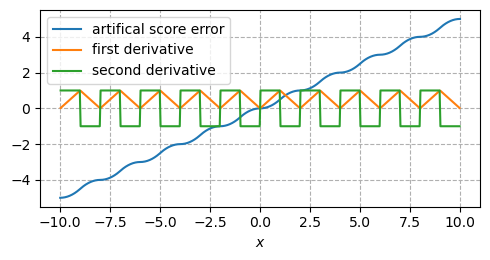

In [6]:
x_l, x_r, Ne = -10, 10, 1000
Δx = (x_r - x_l) / Ne
xx1 = Array(LinRange(x_l, x_r, Ne + 1))
xx = reshape(xx1, (length(xx1), 1))
δ = score_error(1.0, xx)[:,1]
dδ = (δ[3:end] - δ[1:end-2])/(2*Δx)
ddδ = (δ[3:end] + δ[1:end-2] - 2δ[2:end-1])/(Δx^2)
fig, ax = PyPlot.subplots(figsize=(5, 2.7))
ax.plot(xx, δ, label="artifical score error")
ax.grid("on",linestyle="--",)
plot(xx[2:end-1], dδ, label="first derivative")
plot(xx[2:end-1], ddδ, label="second derivative")
ax.set_xlabel(L"x")
ax.legend()
fig.tight_layout()
fig.savefig("score_error.pdf")

# Runge Kutta method

In [7]:
# First-order Runge-Kutta (Euler method) time update.
# Approximates the next state Y_n given the current state Y, time t, and timestep dt.
# compute_v is a function that returns the derivative at a given time and state.
function time_update_RK1(Y, t, dt, compute_v::Function, bs::Beta_Schedule)
    V = compute_v(t, Y)
    Y_n = Y + dt * V
    return Y_n
end

# Second-order Runge-Kutta (Heun's method) time update.
# Provides better accuracy than RK1 by taking an average of slopes.
function time_update_RK2(Y, t, dt, compute_v::Function, bs::Beta_Schedule)
    V1 = compute_v(t, Y)
    V2 = compute_v(t + dt, Y + dt * V1)
    Y_n = Y + 0.5 * dt * (V1 + V2)  # RK2 Update formula
    return Y_n
end

# Third-order Runge-Kutta (RK3) time update.
# Offers high accuracy by evaluating derivatives at multiple points.
function time_update_RK3(Y, t, dt, compute_v::Function, bs::Beta_Schedule)
    V1 = compute_v(t, Y)
    V2 = compute_v(t + 1.0/3.0 * dt, Y + 1.0/3.0 * dt * V1)
    V3 = compute_v(t + 2.0/3.0 * dt, Y + 2.0/3.0 * dt * V2)
    Y_n = Y + (dt / 4) * (V1 + 3*V3)  # RK4 Update formula
    return Y_n
end

# Fourth-order Runge-Kutta (RK4) time update.
# Offers high accuracy by evaluating derivatives at multiple points.
function time_update_RK4(Y, t, dt, compute_v::Function, bs::Beta_Schedule)
    # V1 = compute_v(t, Y)
    # V2 = compute_v(t + 0.5 * dt, Y + 0.5 * dt * V1)
    # V3 = compute_v(t + 0.5 * dt, Y + 0.5 * dt * V2)
    # V4 = compute_v(t + dt, Y + dt * V3)
    # Y_n = Y + (dt / 6) * (V1 + 2*V2 + 2*V3 + V4)  # RK4 Update formula
    # return Y_n
    V = compute_v(t, Y)
    Y_n = Y + (dt / 6) * V
    V .= compute_v(t + 0.5 * dt, Y + 0.5 * dt * V)
    Y_n += (dt / 3) * V
    V .= compute_v(t + 0.5 * dt, Y + 0.5 * dt * V)
    Y_n += (dt / 3) * V
    V .= compute_v(t + dt, Y + dt * V)
    Y_n += (dt / 6) * V  
    return Y_n
end


# General time update dispatcher.
# Selects the integration method based on a string input and calls the appropriate function.
function time_update(Y, t, dt, compute_v::Function, method)
    if startswith(method , "RK1")
        Y_n = time_update_RK1(Y, t, dt, compute_v)
    elseif startswith(method , "RK2")
        Y_n = time_update_RK2(Y, t, dt, compute_v)
        
    elseif startswith(method , "RK3")
        Y_n = time_update_RK3(Y, t, dt, compute_v)
    elseif startswith(method , "RK4")
        Y_n = time_update_RK4(Y, t, dt, compute_v)
    
    else
        error(method, " method has not been implemented " ) 
    end
    
    return Y_n
end

time_update (generic function with 1 method)

# Exponential Runge Kutta method

In [8]:
# First-order Runge-Kutta (Euler method) time update.
# Approximates the next state Y_n given the current state Y, time t, and timestep dt.
# compute_v is a function that returns the derivative at a given time and state.
function time_update_exp_RK1(Y, t, dt, compute_v::Function, bs::Beta_Schedule)
    T = bs.T
    zeta, alpha = compute_zeta(bs, t), compute_alpha(bs, t) 
    _, σ  = compute_mt_covt(bs, bs.T - t)
    V = compute_v(t, Y)
    
    dzeta = compute_zeta(bs, t+dt) - zeta
    _, σ_T_t = compute_mt_covt(bs, bs.T - t - dt)
    Y_n = exp(dzeta)*Y + (σ * exp(dzeta) - σ_T_t) * V
    return Y_n
end

# Second-order Runge-Kutta (Heun's method) time update.
# Provides better accuracy than RK1 by taking an average of slopes.
function time_update_exp_RK2(Y, t, dt, compute_v::Function, bs::Beta_Schedule)
    T = bs.T
    zeta, alpha = compute_zeta(bs, t), compute_alpha(bs, t)
    _, σ  = compute_mt_covt(bs, bs.T - t)
    V1 = compute_v(t, Y)

    c = 1.0
    dzeta2 = compute_zeta(bs, t+c*dt) - zeta
    _, σ_T_t2 = compute_mt_covt(bs, bs.T - t - c*dt)
    dalpha2 = compute_alpha(bs, t + c*dt) - alpha
    V2 = compute_v(t + c*dt, exp(dzeta2)*Y + (σ * exp(dzeta2) - σ_T_t2) * V1)
    
    dzeta = compute_zeta(bs, t+dt) - zeta
    _, σ_T_t = compute_mt_covt(bs, bs.T - t - dt)
    dalpha = compute_alpha(bs, t + dt) - alpha
    Y_n = exp(dzeta)*Y + (σ * exp(dzeta) - σ_T_t)*V1 + 1/dalpha2*(σ*exp(dzeta) - σ_T_t - σ_T_t*dalpha)*(V2 - V1)  # RK2 Update formula
    return Y_n
end

# Fourth-order Runge-Kutta (RK3) time update.
# Offers high accuracy by evaluating derivatives at multiple points.
function time_update_exp_RK3(Y, t, dt, compute_v::Function, bs::Beta_Schedule)
    T = bs.T
    zeta, alpha = compute_zeta(bs, t), compute_alpha(bs, t)
    _, σ  = compute_mt_covt(bs, bs.T - t)
    V1 = compute_v(t, Y)

    c2 = 1/3
    dzeta2 = compute_zeta(bs, t+c2*dt) - zeta
    _, σ_T_t2 = compute_mt_covt(bs, bs.T - t - c2*dt)
    dalpha2 = compute_alpha(bs, t + c2*dt) - alpha
    V2 = compute_v(t + c2*dt, exp(dzeta2)*Y + (σ*exp(dzeta2) - σ_T_t2)*V1)

    c3 = 2/3
    gamma = (3*c3*c3 - 2*c3)/(3*c2*c2 - 2*c2)
    dzeta3 = compute_zeta(bs, t+c3*dt) - zeta
    _, σ_T_t3 = compute_mt_covt(bs, bs.T - t - c3*dt)
    dalpha3 = compute_alpha(bs, t + c3*dt) - alpha
    a32 = (gamma*σ_T_t2*(exp(dalpha2) - 1 - dalpha2) + σ_T_t3*(exp(dalpha3) - 1 - dalpha3))/dalpha2
    V3 = compute_v(t + c3*dt, exp(dzeta3)*Y + (σ*exp(dzeta3) - σ_T_t3)*V1 + a32*(V2 - V1))
    
    dzeta = compute_zeta(bs, t+dt) - zeta
    _, σ_T_t = compute_mt_covt(bs, bs.T - t - dt)
    dalpha = compute_alpha(bs, t + dt) - alpha
    
    b3 = σ_T_t*(exp(dalpha) - 1 - dalpha)/(gamma*dalpha2 + dalpha3)
    Y_n = exp(dzeta)*Y + (σ*exp(dzeta) - σ_T_t)*V1 + gamma*b3*(V2 - V1) + b3*(V3 - V1) # RK2 Update formula
    return Y_n
end



time_update_exp_RK3 (generic function with 1 method)

# ODE solver

We will test different Runge-Kutta schemes for solving the probabilistic flow ODEs.

In [9]:
# General time update dispatcher.
# Selects the integration method based on a string input and calls the appropriate function.
function time_update(Y, t, dt, compute_v::Function, bs::Beta_Schedule, method)
    if startswith(method , "ExpRK1")
        Y_n = time_update_exp_RK1(Y, t, dt, compute_v, bs)
    elseif startswith(method , "ExpRK2")
        Y_n = time_update_exp_RK2(Y, t, dt, compute_v, bs)
    elseif startswith(method , "ExpRK3")
        Y_n = time_update_exp_RK3(Y, t, dt, compute_v, bs)
    elseif startswith(method , "RK1")
        Y_n = time_update_RK1(Y, t, dt, compute_v, bs)
    elseif startswith(method , "RK2")
        Y_n = time_update_RK2(Y, t, dt, compute_v, bs)
    elseif startswith(method , "RK3")
        Y_n = time_update_RK3(Y, t, dt, compute_v, bs)
    elseif startswith(method , "RK4")
        Y_n = time_update_RK4(Y, t, dt, compute_v, bs)
    else
        error(method, " method has not been implemented " ) 
    end
    return Y_n
end



function solve(Nt, Y0, compute_v::Function, bs::Beta_Schedule; save_ts_ind::Array{Int64,1} = Array(0:Nt+1), method::String="RK4") 
    ts = LinRange(0, bs.T, Nt+1)
    τ = 1e-8 
    J, dim = size(Y0)
    Nt_save = length(save_ts_ind)
    Ys = zeros(Nt_save, J, dim)
    save_id = 1
    
    if save_ts_ind[save_id] == 0
        Ys[save_id, :, :] .= Y0
        save_id += 1
    end
    
    Y = copy(Y0)
    for i = 1:Nt
        dt = (i == Nt ? ts[i+1] - ts[i] - τ : ts[i+1] - ts[i])
        t = ts[i]
        Y = time_update(Y, t, dt, compute_v, bs, method)
        if save_id <= Nt_save && save_ts_ind[save_id] == i
            Ys[save_id, :, :] .= Y
            save_id += 1
        end
    end
            
    return Ys, ts[save_ts_ind.+1]
end



solve (generic function with 1 method)

# 1D probabilistic ODE flow

We test 1D kernel reconstruction by sampling particles from both the initial and target densities, followed by reconstruction.

## Compute: discretization error analysis

We use the RK-p scheme, and conjecture the error is $\mathcal{O}(\Delta t^p + \delta)$, $\delta$ is the score error.
For discretization error analysis, we consider the case with $\delta = 10^{-3}$ (very small).
For score error and discretization error analysis, we consider the case with $\delta = \mathcal{O}(\Delta t^p)$.


- solve the 1D probabilistic ODE
- reconstruct the density with kernel
- compute different error indicators, including total variation error, mean error and covariance error.

In [10]:
function one_dim_delta_test(Ny = 40000; seed=42, RUN_SIM = true)
    Random.seed!(seed)
    
    # set for reference
    x_w = [0.2; 0.3; 0.5]
    x_mean = vcat([-6.0;;], [4.0;;], [6.0;;])
    xx_cov = [[0.25;;], [0.25;;], [0.25;;]]
    

    x_l, x_r, Ne = -20, 20, 1000000
    Δx = (x_r - x_l) / Ne
    xx = LinRange(x_l, x_r, Ne + 1)
    xc = (xx[1:Ne] + xx[2:Ne+1])/2.0
    dim = 1
    T_OU, T_betas = 16.0, 2000.0
    linear_betas  = Beta_Schedule(1e-4 , 0.02 , T_betas)
    constant_betas  = Beta_Schedule(2.0 , 2.0 , T_OU)
    
    
    # Compute references
    q0 = compute_qt(x_w, x_mean, xx_cov, Array(reshape(xc, (Ne, 1))) ,0.0, constant_betas)
    
    GM_mean = x_w' * x_mean[:,1]
    GM_cov = 0
    for i = 1:length(x_w)
        GM_cov += x_w[i] * (xx_cov[i][1,1] + (x_mean[i,1] - GM_mean)^2)
    end


    
    methods = ["RK1",  "RK2",  "RK4", 
               "RK1-beta", "RK2-beta", "RK4-beta", 
               "ExpRK1-beta", "ExpRK2-beta", "ExpRK3-beta"]
    method_labels = ["RK1", "RK2", "RK4", 
                     "RK1(β)", "RK2(β)", "RK4(β)", 
                     "ExpRK1(β)", "ExpRK2(β)", "ExpRK3(β)"]
    
    δs = [0.01; 0.02; 0.04; 0.08; 0.16]  
    Nmethod, Nδ = length(methods), length(δs)
    Nts = [512; 512; 512; 512; 512; 512; 512; 512; 512; 512; 512]
    Nsave_ts_ind = 4
    
    cbandwidth(t, T) = (4/(Ny*(dim + 2)))^(1/(dim+4)) * (0.5*t/T + 1.0*(1 - t/T)) 

    # Initialization
    Y0 = rand(Normal(0, 1), (Ny, dim))


    # Store results
    ρ̂T = zeros(Ne)                 #marginal density 
    TVes = zeros(Nmethod, Nδ) 
    rmeanes = zeros(Nmethod, Nδ)   #relative mean error
    rcoves = zeros(Nmethod, Nδ)    #relative covariance error

    
    if RUN_SIM
        Ys = zeros(Nsave_ts_ind, Ny, dim) 
        for imethod = 1:Nmethod
            @info "method = ", methods[imethod]
            for iδ = 1:Nδ 
                save_ts_ind = [0; div(Nts[imethod],2); 3*div(Nts[imethod],4); Nts[imethod]]
                
                betas = (endswith(methods[imethod], "beta") ? linear_betas : constant_betas)
                compute_V(t, xx) = startswith(methods[imethod] , "RK") ? compute_RHS(x_w, x_mean, xx_cov, xx, t, betas, δs[iδ]) : compute_varepsilon(x_w, x_mean, xx_cov, xx, t, betas, δs[iδ])
    
                
                Ys[:, :, :], _ = solve(Nts[imethod], Y0, compute_V, betas; save_ts_ind=save_ts_ind, method=methods[imethod]) 
                kernel = kde(Ys[end,:,1], bandwidth=cbandwidth(0.0, betas.T))
                ρ̂T[:] = pdf(kernel, xc)
    
                
                TVes[imethod, iδ]   = sum(abs.(ρ̂T - q0)) / 2.0 * (xc[2] - xc[1])
                GM_mean_esti = sum(Ys[end, :, 1])/Ny
                rmeanes[imethod, iδ] = abs(GM_mean_esti - GM_mean) / GM_mean
                rcoves[imethod, iδ]  = abs(sum((Ys[end, :, 1] .- GM_mean_esti).^2)/Ny - GM_cov) / GM_cov
            end
        end
        npzwrite("one_dim_delta_test.npz", Dict("TVes" => TVes, "rmeanes" => rmeanes, "rcoves" => rcoves))

    else
        data = npzread("one_dim_delta_test.npz")  
        TVes[:, :], rmeanes[:, :], rcoves[:, :] = data["TVes"], data["rmeanes"], data["rcoves"]
    end


    

    markers = ["x"; "x";  "x"; "o"; "o"; "o"; "^"; "^"; "^";]  
    linestyles = ["dotted"; "dashdot"; "--"; "dotted"; "dashdot"; "--"; "dotted"; "dashdot"; "--"; ]
    alphas =[0.6; 0.8; 1.0]
    
    fig, ax = PyPlot.subplots(nrows = 1, ncols=3, sharex=true, sharey="row", figsize=(7, 3.2))
    for i = 1:3
        ax[i].loglog(δs, 5δs, "-", color = "black", fillstyle = "none", label = L"\epsilon_{\rm score}")
        ax[i].set_xlabel(L"\epsilon_{\rm score}");
    end 
    for imethod = 1:Nmethod
        ax[1].loglog(δs, TVes[imethod, :],    linestyle=linestyles[imethod],  marker = markers[imethod], color = "C"*string(imethod), fillstyle="none", label = method_labels[imethod])  
        ax[2].loglog(δs, rmeanes[imethod, :], linestyle=linestyles[imethod],  marker = markers[imethod], color = "C"*string(imethod), fillstyle="none", label = method_labels[imethod])  
        ax[3].loglog(δs, rcoves[imethod, :],  linestyle=linestyles[imethod],  marker = markers[imethod], color = "C"*string(imethod), fillstyle="none", label = method_labels[imethod])  
    end

    handles, labels = ax[1].get_legend_handles_labels()
    insert!(handles, 2, matplotlib.patches.Patch(color="none"))  # 第1列下方空白
    insert!(labels, 2, "")
    insert!(handles, 3, matplotlib.patches.Patch(color="none"))  # 第1列下方空白
    insert!(labels, 3, "")
    
    fig.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,1.0),ncol=4)
    ax[1].set_ylabel("Total variation error")
    ax[2].set_ylabel("Rel. mean error")
    ax[3].set_ylabel("Rel. covariance error")
    fig.subplots_adjust(bottom=0.2,top=0.75,left=0.1,right=0.95,hspace=0.2)
    fig.savefig("1D-ode-score-error.pdf")
end




function one_dim_test(δ_fix::Bool, Ny = 40000, δ_ref = 0.0; seed=42, RUN_SIM = true)
    Random.seed!(seed)
    
    # set for reference
    x_w = [0.2; 0.3; 0.5]
    x_mean = vcat([-6.0;;], [4.0;;], [6.0;;])
    xx_cov = [[0.25;;], [0.25;;], [0.25;;]]
    
    
    x_l, x_r, Ne = -20, 20, 1000000
    Δx = (x_r - x_l) / Ne
    xx = LinRange(x_l, x_r, Ne + 1)
    xc = (xx[1:Ne] + xx[2:Ne+1])/2.0
    dim = 1
    T_OU, T_betas = 16.0, 2000.0
    linear_betas  = Beta_Schedule(1e-4 , 0.02 , T_betas)
    constant_betas  = Beta_Schedule(2.0 , 2.0, T_OU)
    
    GM_mean = x_w' * x_mean[:,1]
    GM_cov = 0
    for i = 1:length(x_w)
        GM_cov += x_w[i] * (xx_cov[i][1,1] + (x_mean[i,1] - GM_mean)^2)
    end
    q0 = compute_qt(x_w, x_mean, xx_cov, Array(reshape(xc, (Ne, 1))), 0.0, constant_betas)

    # Setup
    Nts = (δ_fix ? [256 128 64 32;  128 64 32 16;  64 32 16 8; 
                    256 128 64 32;  128 64 32 16;  64 32 16 8; 
                    256 128 64 32;  128 64 32 16;  64 32 16 8] : 
                   [512 256 128 64; 256 128 64 32; 128 64 32 16;
                    512 256 128 64; 256 128 64 32; 128 64 32 16;
                    512 256 128 64; 256 128 64 32; 128 64 32 16;])
    
    methods = ["RK1",  "RK2",  "RK4", 
               "RK1-beta", "RK2-beta", "RK4-beta", 
               "ExpRK1-beta", "ExpRK2-beta", "ExpRK3-beta"]
    method_labels = ["RK1", "RK2", "RK4", 
                     "RK1(β)", "RK2(β)", "RK4(β)", 
                     "ExpRK1(β)", "ExpRK2(β)", "ExpRK3(β)"]
    orders = [1.0; 2.0; 4.0; 1.0; 2.0; 4.0; 1.0; 2.0; 3.0;]
    Nmethod, Nt = length(methods), size(Nts,2)
    Nsave_ts_ind = 4

    # Initial condition
    Y0 = rand(Normal(0, 1), (Ny, dim))
    # kernel reconstruction
    cbandwidth(t,T) = (4/(Ny*(dim + 2)))^(1/(dim+4)) * (0.5*t/T + 1.0*(1 - t/T)) 
    

    # Store results
    ρ̂Ts = zeros(Nmethod, Nsave_ts_ind, Ne) # marginal density 
    ρ̂T = zeros(Ne)                         # marginal density 
    TVes = zeros(Nmethod, Nt) 
    rmeanes = zeros(Nmethod, Nt)           #relative mean error
    rcoves = zeros(Nmethod, Nt)            #relative covariance error


    
    
    if RUN_SIM
        Ys = zeros(Nsave_ts_ind, Ny, dim) 
        for imethod = 1:Nmethod
            for it = 1:Nt 
    
                betas = (endswith(methods[imethod], "beta") ? linear_betas : constant_betas)
                
                δ = (δ_fix ? δ_ref : δ_ref*(Nts[imethod,end]/Nts[imethod,it])^orders[imethod]) # maximum error is δ_ref
                ts = LinRange(0, betas.T, Nts[imethod,it]+1)
                save_ts_ind = [0; div(Nts[imethod,it],2); 3*div(Nts[imethod,it],4); Nts[imethod,it]]
                
                compute_V(t, xx) = startswith(methods[imethod] , "RK") ? compute_RHS(x_w, x_mean, xx_cov, xx, t, betas, δ) : compute_varepsilon(x_w, x_mean, xx_cov, xx, t, betas, δ)
    
                Ys[:, :, :], _ = solve(Nts[imethod,it], Y0, compute_V, betas; save_ts_ind=save_ts_ind, method=methods[imethod]) 
                kernel = kde(Ys[end,:,1], bandwidth=cbandwidth(0.0, betas.T))
                
                ρ̂T[:] = pdf(kernel, xc)
                
                TVes[imethod, it]   = sum(abs.(ρ̂T - q0)) / 2.0 * (xc[2] - xc[1])
                GM_mean_esti = sum(Ys[end, :,1])/Ny
                rmeanes[imethod, it] = abs(GM_mean_esti - GM_mean) / GM_mean
                rcoves[imethod, it]  = abs(sum((Ys[end, :,1] .- GM_mean_esti).^2)/Ny - GM_cov) / GM_cov
    
                if it == Nt-1 # store results for visualization
                    for i = 1:Nsave_ts_ind
                        kernel = kde(Ys[i, :, 1], bandwidth=cbandwidth(ts[i], betas.T))
                        ρ̂Ts[imethod, i, :] = pdf(kernel, xc)
                    end
                end
            end
        end
        npzwrite("one_dim_test_δ_fix_"*string(δ_fix)*".npz", Dict("rhoTs" => ρ̂Ts, "TVes" => TVes, "rmeanes" => rmeanes, "rcoves" => rcoves))

    else
        data = npzread("one_dim_test_δ_fix_"*string(δ_fix)*".npz")  
        ρ̂Ts[:,:,:], TVes[:, :], rmeanes[:, :], rcoves[:, :] = data["rhoTs"], data["TVes"], data["rmeanes"], data["rcoves"]
    end
    
    @info "TVes ", TVes
    @info "rmeanes ", rmeanes
    @info "rcoves ", rcoves


    
    ncols = 4
    markers = ["x"; "x"; "x"; "o"; "o"; "o"; "^"; "^"; "^";]  
    linestyles = ["dotted"; "dashdot";  "--"; "dotted"; "dashdot";  "--"; "dotted"; "dashdot"; "--"; ]
    alphas =[0.8; 0.8; 0.8; 0.8; 0.8; 0.8; 0.8; 0.8; 0.8; 0.8; 0.8;]

    fig, ax = PyPlot.subplots(ncols=1, sharex=true, sharey="row", figsize=(6, 2.7))
    
    # plot references
    qt = compute_qt(x_w, x_mean, xx_cov, Array(reshape(xc, (Ne, 1))), 0.0, constant_betas)
    ax.plot(xc, qt,  "-", color = "grey", fillstyle="none", label="reference")
        
    for imethod = 1:Nmethod
        ρ̂t = ρ̂Ts[imethod, end, :]
        ax.plot(xc, ρ̂t, linestyle=linestyles[imethod], marker=markers[imethod], color = "C"*string(imethod), fillstyle="none", markevery=div(Ne,5), markersize = 3, label=method_labels[imethod])
        ax.set_xlim([-10.,10.])
    end
    handles, labels = ax.get_legend_handles_labels()
    
    fig.legend(handles,labels,loc = "center left",bbox_to_anchor=(0.0,0.5),ncols=1)
    fig.subplots_adjust(bottom=0.1,top=0.95,left=0.35,right=0.95,hspace=0.2)
    fig.savefig("1D-ode-RK-density"*(δ_fix ? "(discretization-error).pdf" : "(total-error).pdf"))
    
    
    hs = 1.0 ./ Nts
    fig, ax = PyPlot.subplots(nrows = 1, ncols=3, sharex=true, sharey=true, figsize=(7, 3.2))
    if δ_fix
        for i = 1:3
            ax[i].loglog(hs[1,:],   0.5*(T_OU*hs[1,:]).^1,  linestyle="dotted",  color = "black", fillstyle="none", label=L"H")
            ax[i].loglog(hs[2,:],   0.1*(T_OU*hs[2,:]).^2,  linestyle="dashdot", color = "black", fillstyle="none", label=L"H²")
            ax[i].loglog(hs[3,:], 0.005*(T_OU*hs[3,:]).^4, linestyle="-",       color = "black", fillstyle="none", label=L"H⁴")
        end
    else
        for i = 1:3
            ax[i].loglog(hs[1,:], 2.0*(T_OU*hs[1,:]).^1,  linestyle="dotted",  color = "black", fillstyle="none", label=L"H")
            ax[i].loglog(hs[2,:], 0.5*(T_OU*hs[2,:]).^2,  linestyle="dashdot", color = "black", fillstyle="none", label=L"H²")
            ax[i].loglog(hs[3,:], 0.1*(T_OU*hs[3,:]).^4, linestyle="-",       color = "black", fillstyle="none", label=L"H⁴")
        end
    end
    
    for imethod = 1:Nmethod
        ax[1].loglog(hs[imethod,:], TVes[imethod, :],    linestyle=linestyles[imethod], marker=markers[imethod], color = "C"*string(imethod), alpha =alphas[imethod], fillstyle="none", label = method_labels[imethod])  
        ax[2].loglog(hs[imethod,:], rmeanes[imethod, :], linestyle=linestyles[imethod], marker=markers[imethod], color = "C"*string(imethod), alpha =alphas[imethod], fillstyle="none", label = method_labels[imethod])  
        ax[3].loglog(hs[imethod,:], rcoves[imethod, :],  linestyle=linestyles[imethod], marker=markers[imethod], color = "C"*string(imethod), alpha =alphas[imethod], fillstyle="none", label = method_labels[imethod])  
    end
    for i = 1:3
        ax[i].set_xlabel(L"H/T");
        ax[i].set_xticks([0.01 ; 0.1]) 
    end

    
    handles, labels = ax[1].get_legend_handles_labels()
    fig.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,1.0),ncol=4)

    
    ax[1].set_ylabel("Total variation error")
    ax[2].set_ylabel("Rel. mean error")
    ax[3].set_ylabel("Rel. covariance error")

    fig.subplots_adjust(bottom=0.2,top=0.75,left=0.1,right=0.95,hspace=0.2)
    fig.savefig("1D-ode-RK"*(δ_fix ? "(discretization-error).pdf" : "(total-error).pdf"))

end

one_dim_test (generic function with 3 methods)

In [11]:
Ny = 100

100

[ Info: ("method = ", "RK1")
[ Info: ("method = ", "RK2")
[ Info: ("method = ", "RK4")
[ Info: ("method = ", "RK1-beta")
[ Info: ("method = ", "RK2-beta")
[ Info: ("method = ", "RK4-beta")
[ Info: ("method = ", "ExpRK1-beta")
[ Info: ("method = ", "ExpRK2-beta")
[ Info: ("method = ", "ExpRK3-beta")


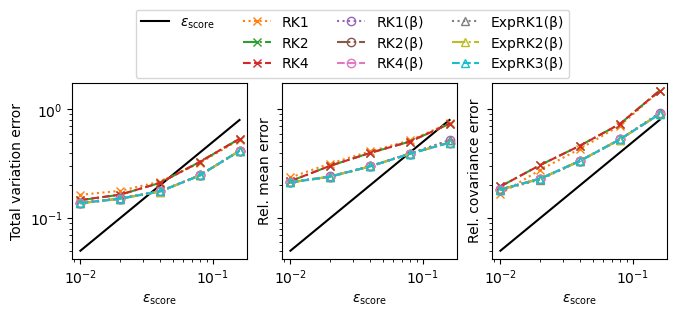

In [95]:
one_dim_delta_test(Ny; seed=111, RUN_SIM=true)

[ Info: ("TVes ", [0.14794800398641103 0.19827352050433697 0.32139327105375326 0.5131496150421354; 0.1198478819042387 0.11696051061470605 0.2953028380054288 0.5795885137436594; 0.12395730109675722 0.11850820924853371 0.10845295770996011 0.37041620115974466; 0.12630397382774028 0.12833585975719522 0.1326607758873881 0.14215787860646437; 0.12457459858742051 0.12494608791618615 0.12632478006197753 0.13281035643047046; 0.12444000987356583 0.124489121068964 0.1249116198714035 0.12851505798071458; 0.12338397588217255 0.12261408979627356 0.1215917598767802 0.12122092675369645; 0.12360353064381546 0.12230581363508523 0.11880467760430166 0.11150401007407691; 0.1256156922440953 0.12745827520321373 0.1314294807998118 0.12679403750853477])
[ Info: ("rmeanes ", [0.2058306757367423 0.23757975344384974 0.29797093475302566 0.4017700439209204; 0.17275638091024068 0.1716099466885733 0.16927392693833157 0.18050990269023984; 0.17304850015763762 0.17268879802892023 0.1765161873626339 0.22334149123721106; 0

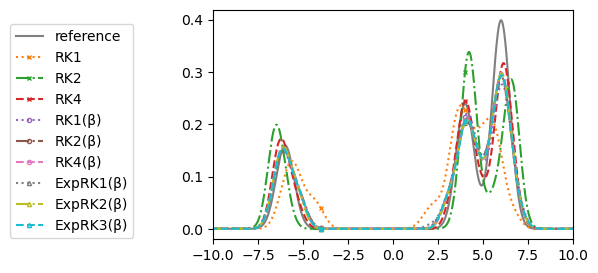

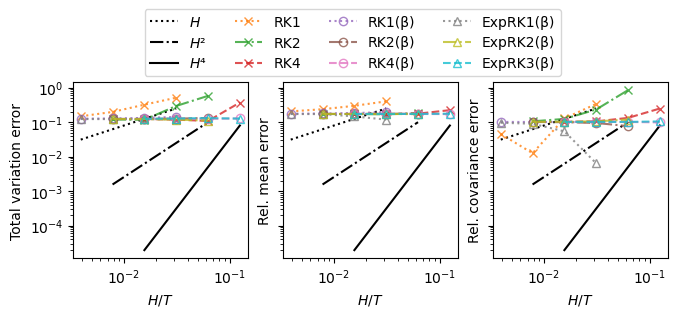

In [96]:
one_dim_test(true,  Ny, 1.0e-6; seed=42, RUN_SIM=true)  

[ Info: ("TVes ", [0.15217591856509305 0.1662680121198831 0.21011073413688738 0.37177126864550314; 0.12591402951451847 0.1332429262784237 0.17544322878352925 0.49451590146109703; 0.12444676990739072 0.12454607257503301 0.13174279970969952 0.39357161695147014; 0.14117187486545854 0.16495582916523827 0.19526207607833695 0.30819073622409643; 0.12599972425288114 0.13221971242668779 0.16187138902442696 0.29335241108205684; 0.12445749749981407 0.12480306541291297 0.1322188546293971 0.2979882248161381; 0.1395365754944885 0.16037782174082646 0.18908871842246078 0.30108103252790974; 0.12561925209824795 0.13132952511774013 0.15978591793650582 0.28305666532648655; 0.12509463443418925 0.12715541386452717 0.14334506968577942 0.31083961121662895])
[ Info: ("rmeanes ", [0.298065740535385 0.34827208264596715 0.41050736929222637 0.5260294830309394; 0.1745913733320572 0.2283060278263013 0.32266698061202953 0.42548783531721757; 0.17313948754284278 0.17342718357285478 0.22796550127321202 0.423072595244590

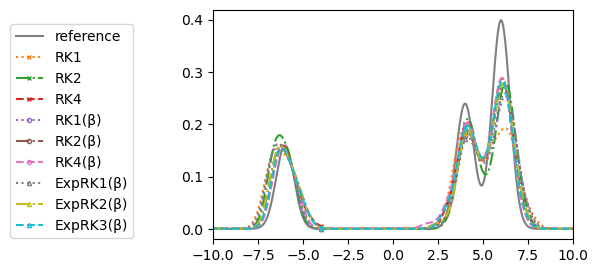

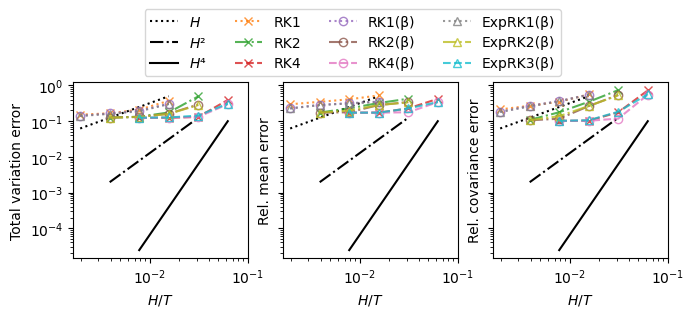

In [97]:
one_dim_test(false, Ny, 1.0e-1; seed=42, RUN_SIM=true)

# High dimensional probabilistic flow ODE

## Setup 
We follow the setup in Albergo, Michael S., Nicholas M. Boffi, and Eric Vanden-Eijnden. "Stochastic interpolants: A unifying framework for flows and diffusions." arXiv preprint arXiv:2303.08797 (2023). The target density is a 5-mode Gaussian mixture.


## Kernel reconstruction
We test 1D kernel reconstruction by sampling particles from both the initial and target densities, projecting them onto 1D, and then performing reconstruction.


## Compute: score error and discretization error analysis
We use the RK-p scheme, and conjecture the error is $\mathcal{O}(\Delta t^p + \delta)$, $\delta$ is the score error.
For discretization error analysis, we consider the case with $\delta = 10^{-3}$ (very small).
For score error and discretization error analysis, we consider the case with $\delta = \mathcal{O}(\Delta t^p)$.


- solve the high dimensional probabilistic ODE ($d = 8, 32, 128$)
- reconstruct the 1D marginal density with kernel
- compute different error indicators, including total variation error, mean error and covariance error.

In [17]:
function extract_submatrix(xx_cov_high, dim, cov_diag)
    xx_cov = (cov_diag ? [Diagonal(diag(xx_cov_high[i])[1:dim]) for i = 1:length(xx_cov_high)] : [xx_cov_high[i][1:dim,1:dim] for i = 1:length(xx_cov_high)])
    return xx_cov
end
    
function high_dim_test(δ_fix::Bool, Ny = 40000, δ_ref = 0.0, method = "RK1"; seed=42)
    Random.seed!(seed)
    
    dim_high = 128
    N_modes = 5
    x_w =  rand(Uniform(0,1), N_modes) 
    x_w = x_w/sum(x_w)
    
    x_mean_high = 3.0*rand(Normal(0, 1), (N_modes, dim_high))
    COV_DIAG = false
    
    xx_cov_high = []
    
    
    for i = 1:N_modes
        if COV_DIAG
            W = rand(Normal(0, 1), (dim_high))
            push!(xx_cov_high, 0.25*(Diagonal(W.*W) + I)/2.0)
        else
            W = rand(Normal(0, 1), (dim_high, dim_high))
            push!(xx_cov_high, 0.25*(W'*W/dim_high + I)/2.0)
        end
    end



    T_OU, T_betas = 16.0, 2000.0
    linear_betas  = Beta_Schedule(1e-4 , 0.02 , T_betas)
    constant_betas  = Beta_Schedule(2.0 , 2.0 , T_OU)
    
    dim, x_mean, xx_cov = dim_high, x_mean_high, xx_cov_high 
    GM_mean = x_mean' * x_w 
    GM_cov = zeros(dim, dim)
    for i = 1:N_modes
        GM_cov += x_w[i] * (xx_cov[i] + (x_mean[i,:] - GM_mean)*(x_mean[i,:] - GM_mean)')
    end
    x_l, x_r, Ne = -20, 20, 1000000
    Δx = (x_r - x_l) / Ne
    xx = LinRange(x_l, x_r, Ne + 1)
    xc = (xx[1:Ne] + xx[2:Ne+1])/2.0
    q0 = compute_qt(x_w, x_mean[:, 1:1], [xx_cov[i][1:1,1:1] for i = 1:N_modes], Array(reshape(xc, (Ne, 1))), 0.0, constant_betas)        
    
 
    # kernel reconstruction
    cbandwidth(t,T) = (4/(Ny*(1 + 2)))^(1/(1+4)) * (0.5*t/T + 1.0*(1 - t/T)) 
    




    # Setup 
    dims = [8; 32; 128]
    Nmethod = 1
    orders = [1.0; 2.0; 4.0; 2.0; 4.0]
    Nts = ( (startswith(method, "RK3") || startswith(method, "RK4")) ? [128 64 32 16] : [256 128 64 32]) 
    # Nts = [256 128 64 32;  256 128 64 32;  128 64 32 16;  256 128 64 32;  128 64 32 16] 
    Nt, Ndim = size(Nts,2), length(dims)
    Nsave_ts_ind = 4


    # Store results
    ρ̂Ts = zeros(Nmethod, Nsave_ts_ind, Ne) # marginal density 
    ρ̂T = zeros(Ne) # marginal density 
    TVes = zeros(Ndim, Nmethod, Nt) 
    rmeanes = zeros(Ndim, Nmethod, Nt)   #relative mean error
    rcoves = zeros(Ndim, Nmethod, Nt)    #relative covariance error


    # Initial condition
    Y0_high = rand(Normal(0, 1), (Ny, dim_high))
    Y0 = Y0_high 

    
    Ys = zeros(Nsave_ts_ind, Ny, dims[end]) 
    for idim = 1:Ndim
        dim = dims[idim]
        x_mean = x_mean_high[:, 1:dim]
        xx_cov = extract_submatrix(xx_cov_high, dim, COV_DIAG)
        Y0 = Y0_high[:, 1:dim]
        # reference
        GM_mean = x_mean' * x_w 
        GM_cov = zeros(dim, dim)
        for i = 1:N_modes
            GM_cov += x_w[i] * (xx_cov[i] + (x_mean[i,:] - GM_mean)*(x_mean[i,:] - GM_mean)')
        end
        for imethod = 1:Nmethod
            for it = 1:Nt 
                @info dim, method, Nts[imethod, it]
                
                betas = (endswith(method, "beta") ? linear_betas : constant_betas)
                δ = (δ_fix ? δ_ref : δ_ref*(Nts[imethod,end]/Nts[imethod,it])^orders[imethod]) # maximum error is δ_ref
                ts = LinRange(0, betas.T, Nts[imethod,it]+1)
                save_ts_ind = [0; div(Nts[imethod,it],2); 3*div(Nts[imethod,it],4); Nts[imethod,it]]
            
                compute_V(t, xx) = startswith(method, "RK") ? compute_RHS(x_w, x_mean, xx_cov, xx, t, betas, δ) : compute_varepsilon(x_w, x_mean, xx_cov, xx, t, betas, δ)


                Ys[:, :, 1:dim], _ = solve(Nts[imethod, it], Y0, compute_V, betas; save_ts_ind=save_ts_ind, method=method) 
                kernel = kde(Ys[end, :,1], bandwidth=cbandwidth(betas.T, betas.T)) #project to the first component

           
                
                ρ̂T[:] = pdf(kernel, xc)
                TVes[idim, imethod, it]   = sum(abs.(ρ̂T - q0)) / 2.0 * (xc[2] - xc[1])
                GM_mean_esti = sum(Ys[end, :,1:dim], dims=1)[:]/Ny
                rmeanes[idim, imethod, it] = norm(GM_mean_esti - GM_mean) / norm(GM_mean)
                rcoves[idim, imethod, it]  = norm((Ys[end, :,1:dim] - ones(Ny)*GM_mean_esti')'*(Ys[end, :,1:dim] - ones(Ny)*GM_mean_esti')/Ny - GM_cov) / norm(GM_cov)
    


                
                if idim == Ndim && it == Nt # store results for visualization
                    for i = 1:Nsave_ts_ind
                        kernel = kde(Ys[i, :, 1], bandwidth=cbandwidth(ts[i], betas.T))
                        ρ̂Ts[imethod, i, :] = pdf(kernel, xc)
                    end
                end

                
            end
        end
    end
    npzwrite(method*"_high_dim.npz", Dict("density" => ρ̂Ts, "TVes" => TVes, "rmeanes" => rmeanes, "rcoves" => rcoves))
end




function high_dim_test_plot(δ_fix::Bool, Ny = 40000, δ_ref = 0.0; seed=42)
    Random.seed!(seed)
    
    dim_high = 128
    N_modes = 5
    x_w =  rand(Uniform(0,1), N_modes) 
    x_w = x_w/sum(x_w)
    
    x_mean_high = 3.0*rand(Normal(0, 1), (N_modes, dim_high))
    COV_DIAG = false
    
    xx_cov_high = []
    
    
    for i = 1:N_modes
        if COV_DIAG
            W = rand(Normal(0, 1), (dim_high))
            push!(xx_cov_high, 0.25*(Diagonal(W.*W) + I)/2.0)
        else
            W = rand(Normal(0, 1), (dim_high, dim_high))
            push!(xx_cov_high, 0.25*(W'*W/dim_high + I)/2.0)
        end
    end



    T_OU, T_betas = 16.0, 2000.0
    linear_betas  = Beta_Schedule(1e-4 , 0.02 , T_betas)
    constant_betas  = Beta_Schedule(2.0 , 2.0 , T_OU)
    
    dim, x_mean, xx_cov = dim_high, x_mean_high, xx_cov_high 
    GM_mean = x_mean' * x_w 
    GM_cov = zeros(dim, dim)
    for i = 1:N_modes
        GM_cov += x_w[i] * (xx_cov[i] + (x_mean[i,:] - GM_mean)*(x_mean[i,:] - GM_mean)')
    end
    x_l, x_r, Ne = -20, 20, 1000000
    Δx = (x_r - x_l) / Ne
    xx = LinRange(x_l, x_r, Ne + 1)
    xc = (xx[1:Ne] + xx[2:Ne+1])/2.0
    q0 = compute_qt(x_w, x_mean[:, 1:1], [xx_cov[i][1:1,1:1] for i = 1:N_modes], Array(reshape(xc, (Ne, 1))), 0.0, constant_betas)        
    
 
    # kernel reconstruction
    cbandwidth(t,T) = (4/(Ny*(1 + 2)))^(1/(1+4)) * (0.5*t/T + 1.0*(1 - t/T)) 
    




    # Setup 
    dims = [8; 32; 128]
    methods = ["RK1";  "RK2";    "RK4"]
    method_labels = ["RK1";  "RK2";   "RK4"]
    orders = [1.0; 2.0; 3.0; 4.0]
    Nts = [256 128 64 32;  256 128 64 32;   128 64 32 16] 
    Nmethod, Nt, Ndim = length(methods), size(Nts,2), length(dims)
    Nsave_ts_ind = 4


    # Store results
    ρ̂Ts = zeros(Nmethod, Nsave_ts_ind, Ne) # marginal density 
    ρ̂T = zeros(Ne) # marginal density 
    TVes = zeros(Ndim, Nmethod, Nt) 
    rmeanes = zeros(Ndim, Nmethod, Nt)   #relative mean error
    rcoves = zeros(Ndim, Nmethod, Nt)    #relative covariance error

    for imethod = 1:Nmethod
        data = npzread(methods[imethod]*"_high_dim.npz")
        ρ̂Ts[imethod, :, :] = data["density"]
        TVes[:, imethod, :] = data["TVes"] 
        rmeanes[:, imethod, :] = data["rmeanes"] 
        rcoves[:, imethod, :] = data["rcoves"]
    end

    # plot marginal for 128 dimensional problem
    ncols = 4
    markers = ["x"; "o"; "^"; "D"; "v"]  
    linestyles = ["dotted"; "dashdot"; "--";]
    alphas =[0.8; 0.8; 0.8; 0.8; 0.8]
    
    idim = 3 
    dim = dims[idim]
    x_mean = x_mean_high[:, 1:dim]
    xx_cov = extract_submatrix(xx_cov_high, dim, COV_DIAG)
    
    
    fig, ax = PyPlot.subplots(ncols=1, sharex=true, sharey="row", figsize=(5, 2.2))
    ## plot reference at the end time
    qt = compute_qt(x_w, x_mean[:,1:1], [xx_cov[i][1:1,1:1] for i = 1:N_modes], Array(reshape(xc, (Ne, 1))), 0.0, constant_betas)
    ax.plot(xc, qt,  "-", color = "grey", fillstyle="none", label="reference")
    
    for imethod = 1:Nmethod
        ρ̂t = ρ̂Ts[imethod, end, :]
        ax.plot(xc, ρ̂t, linestyle=linestyles[imethod], marker=markers[imethod], color = "C"*string(imethod), fillstyle="none", markevery=div(Ne, 10), markersize = 3, label=method_labels[imethod])
        ax.set_xlim([-10.,10.])
    end
    
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles,labels,loc = "center left",bbox_to_anchor=(0.0,0.5),ncols=1)
    fig.subplots_adjust(bottom=0.12, top=0.95, left=0.35, right=0.95, hspace=0.2)
    fig.savefig("high-D-ode-density"*(δ_fix ? "(discretization-error).pdf" : "(total-error).pdf"))


    fig, ax = PyPlot.subplots(nrows = 1, ncols=3, sharex=true, sharey=true, figsize=(7, 3.2))
    hs = 1.0 ./ Nts
    for i = 1:3
        ax[i].loglog(hs[1,:], 0.5*(T_OU*hs[1,:]).^1, linestyle="dotted", color = "black", fillstyle="none", label="H")
        ax[i].loglog(hs[2,:], 0.5*(T_OU*hs[2,:]).^2, linestyle="dashdot", color = "black", fillstyle="none", label="H²")
        ax[i].loglog(hs[3,:], 0.2*(T_OU*hs[3,:]).^4, linestyle="--", color = "black", fillstyle="none", label="H⁴")
    end
    
    linestyles = ["dotted"; "dashdot"; "--"]
    alphas =[0.8; 0.8; 0.8]
    Hlabels = ["H", "H²", "H⁴"]
    for imethod = 1:Nmethod 
        for idim = 1:Ndim
            label = (imethod == Nmethod ? method_labels[imethod]*"(d = "* string(dims[idim]) * ")" : method_labels[imethod])
            ax[1].loglog(hs[imethod,:], TVes[idim, imethod, :],    linestyle=linestyles[imethod], marker=markers[idim], color = "C"*string((idim-1)*Ndim+imethod), alpha =alphas[idim], fillstyle="none", label = label)  
            ax[2].loglog(hs[imethod,:], rmeanes[idim, imethod, :], linestyle=linestyles[imethod], marker=markers[idim], color = "C"*string((idim-1)*Ndim+imethod), alpha =alphas[idim], fillstyle="none", label = label)  
            ax[3].loglog(hs[imethod,:], rcoves[idim, imethod, :],  linestyle=linestyles[imethod], marker=markers[idim], color = "C"*string((idim-1)*Ndim+imethod), alpha =alphas[idim], fillstyle="none", label = label)  
        end
    end
    for i = 1:3
        ax[i].set_xlabel(L"H/T");
        ax[i].set_xticks([0.01 ; 0.1]) 
    end
    handles, labels = ax[1].get_legend_handles_labels()
    fig.legend(handles, labels, loc = "upper center", bbox_to_anchor=(0.5,1.0), ncols=Nmethod+1)
    ax[1].set_ylabel("Total variation error")
    ax[2].set_ylabel("Rel. mean error")
    ax[3].set_ylabel("Rel. covariance error")

    fig.subplots_adjust(bottom=0.16,top=0.75,left=0.1,right=0.95,hspace=0.2)
    fig.savefig("high-D-ode-error"*(δ_fix ? "(discretization-error).pdf" : "(total-error).pdf"))
end

high_dim_test_plot (generic function with 3 methods)

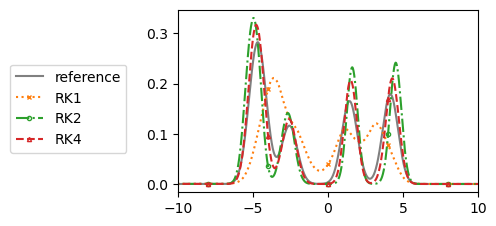

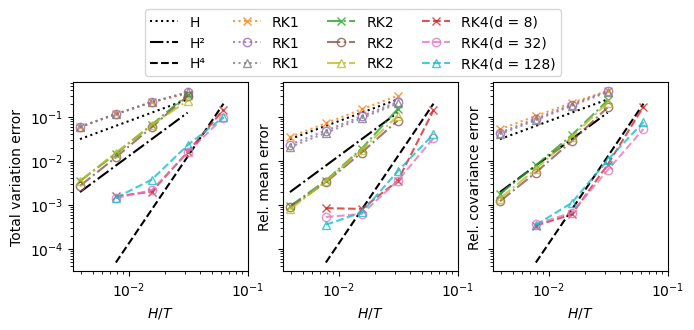

In [18]:
Ny = 10^7
# high_dim_test(false, Ny, 1.0e-1, "RK1"; seed=42)
# high_dim_test(false, Ny, 1.0e-1, "RK2"; seed=42)
# high_dim_test(false, Ny, 1.0e-1, "RK4"; seed=42)
high_dim_test_plot(false, Ny, 1.0e-1; seed=42)